In [122]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from backprop import Value
from nn import Neuron, Layer, MLP

In [123]:
# understanding derivatives
def f(x):
    return 3*x**2 - 4*x + 5

In [124]:
f(3.0)

20.0

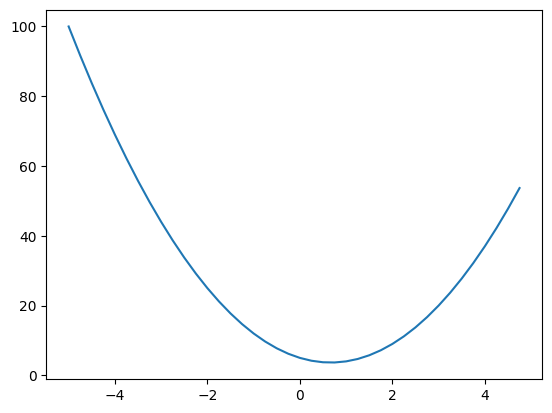

In [125]:
# let's plot the function to determine shape (parabola)
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [126]:
# now calculate derivatives (3*2*x - 4)
h = 0.001
x = 3.0
(f(x + h) - f(x))/h

14.00300000000243

In [127]:
# bit more complex:
def f(a, b, c):
    return a * b + c

a = 2.0
b = -3.0
c = 10.0
print(f(a, b, c))

4.0


In [128]:
h = 0.001
d1 = f(a, b, c)
c += h
d2 = f(a, b, c)
print('d1', d1)
print('d2', d2)

d1 4.0
d2 4.0009999999999994


In [129]:
print('slope', (d2 - d1)/h)

slope 0.9999999999994458


In [130]:
math.exp(1)

2.718281828459045

In [131]:
from graphviz import Digraph

def trace(root):
    # build a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir})

    nodes, edges = trace(root)
    
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph create a rectangular ('record') node for it
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of operation create op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 node to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

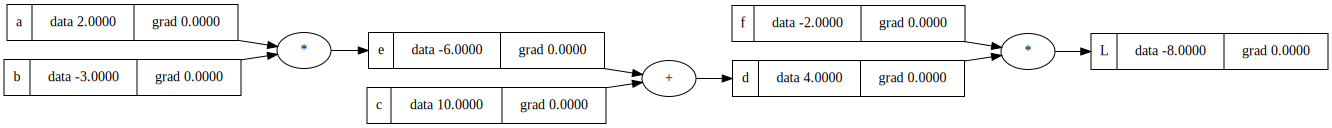

In [132]:
h = 0.001
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b
e.label='e'
d = e + c
d.label = 'd'
f = Value(-2.0, label='f')
L = d*f
L.label='L'

draw_dot(L)

### Manual backpropagation

-2.000000000000668


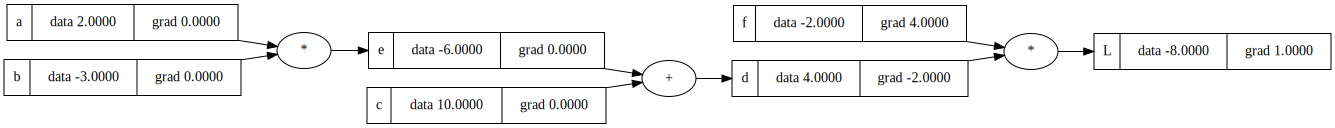

In [133]:
# https://www.youtube.com/watch?v=VMj-3S1tku0&ab_channel=AndrejKarpathy

# if we change L by h we expect the entire function to change by h so the derivative should be 1
# proof:
# dL/dL = 1
# function changes linearly

# for * node we can determine gradients this way:
# L = d * f
# dL/dd =? f
# change d (x) by tiny amount h:
# (f(x+h)-f(x))/h = (fx + fh - fx)/h = fh/h = f

# this will mean:
# f.grad = d
# d.grad = f


L.grad = 1
d.grad = -2.0
f.grad = 4.0

def lol():
    h = 0.001
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b
    e.label='e'
    d = e + c
    d.label = 'd'
    f = Value(-2.0, label='f')
    L = d*f
    L.label='L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b
    e.label='e'
    d = e + c
    d.label = 'd'
    d.data += h # for gardient check... numerical verification that we calculated f.grade correctly
    f = Value(-2.0, label='f')
    L = d*f
    L.label='L'
    L2 = L.data

    print((L2-L1) / h)

lol()

draw_dot(L)


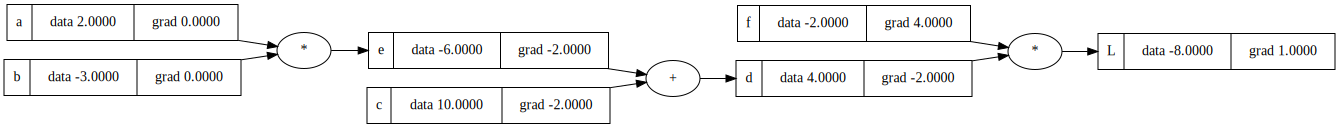

In [134]:
'''
next we need to understand dL by dc, i.e. dL/dc
focusing on d only we know that L get impacted by c through d so what is the impact of c on d?
dd / dc = ?
we know that d = c + e so dd/dc = 1.0
proof (input c+e for x):
(f(x+h) - f(x))/h = (c + h + e) - (c + e) / h = h/h = 1

dd / de = 1.0 - this is just local node derivative and we need to continue

WANT:
dL by dc i.e. dL / dc

KNOW:
dL / dd

applying chain rule:
dL/de = dL/dd * dd/de = -2.0 * 1.0 = -2.0
'''
c.grad = -2.0
e.grad = -2.0 # explain why :-)

draw_dot(L)

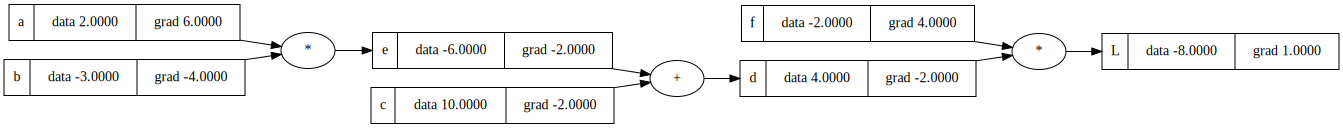

In [135]:
'''
let's do the final part here finding dL / db and dL / da
we know that e = a * b
first we will do de / da which we expect to be b
and symetrically de / db = a

these are just local so we need to continue applying chain rule knowing that e = a * b

WANT:
dL / da

KNOW:
dL / dd; dL / de; dd/de but we just need the node we are backpropagating from i.e. dL/de and 
we are not traversing across entire chain

WRONG: dL/dd * dd/de * de/da
RIGHT: dL/de * de/da

applying chain rule:
dL / da = dL/de * de/da = -2.0 * b = -3.0 == 6.0
dl / db = dL/de * de/db = -2.0 * a = 2.0 == -4
'''
a.grad = 6.0
b.grad = -4.0
draw_dot(L)

In [136]:
'''
Let's increase the value of some leaf nodes by 0.01 to see impact on L
'''
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L)

Value(data=-7.286496, grad=0.0)


### Manual backpropagation example with neuron

In [137]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias
b = Value(6.8813735870195432, label='b')
# according to neuron model (wikipedia)
# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

In [138]:
# take this through the activation function tanh
# tanh we need to implement in Value class (check code above)
o = n.tanh(); o.label = 'o'

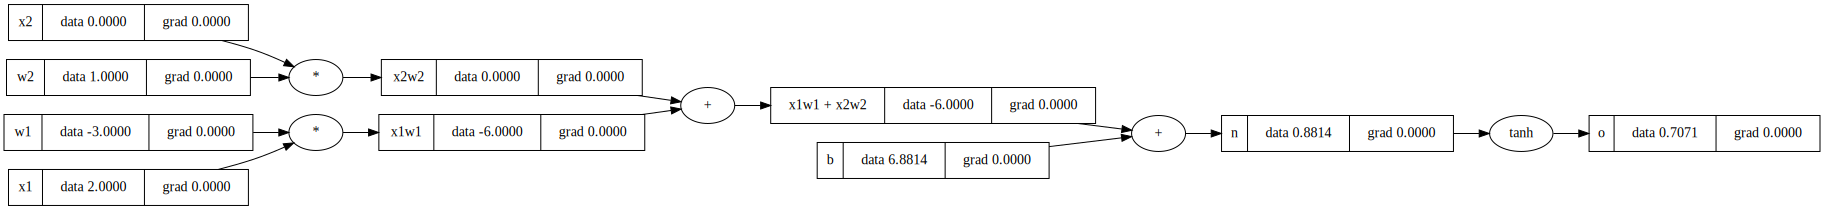

In [139]:
draw_dot(o)

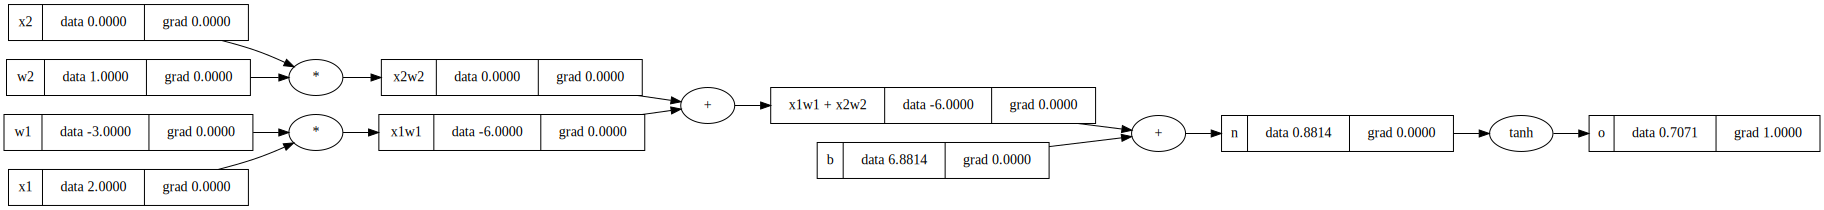

In [140]:
# starting the backpropagation
# STEP 1: what is the derivative of o with respect to o? it's 1
o.grad = 1
draw_dot(o)

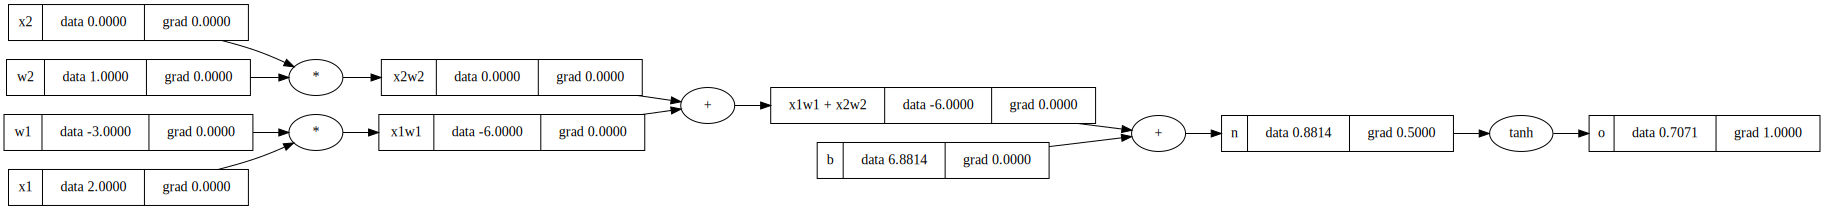

In [141]:
# STEP 2: if o = tanh(n) what is do/dn?
# do/dn = 1 - (tanh(n**2)) = 1 - o**2
n.grad = 1 - o.data**2
draw_dot(o)

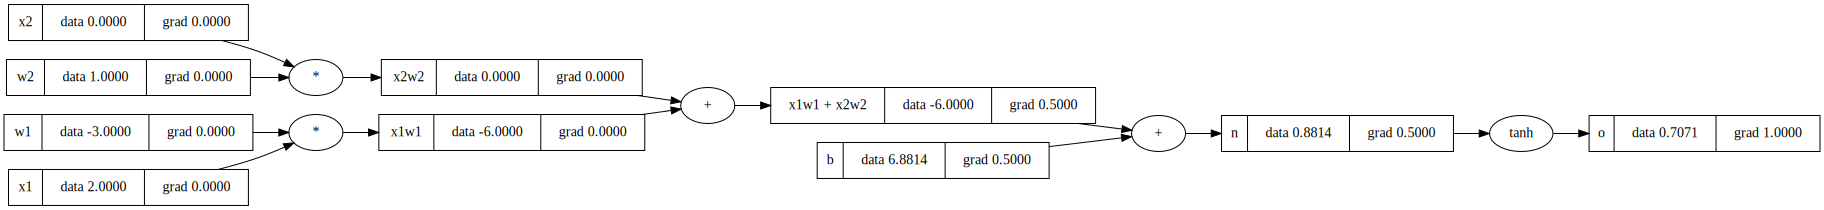

In [142]:
# STEP 3: What is do / db
# WE KNOW that + operation just routes next gradient so 0.5 will go both into b and x1w1+x2w2
b.grad = 0.5
x1w1x2w2.grad = 0.5
draw_dot(o)

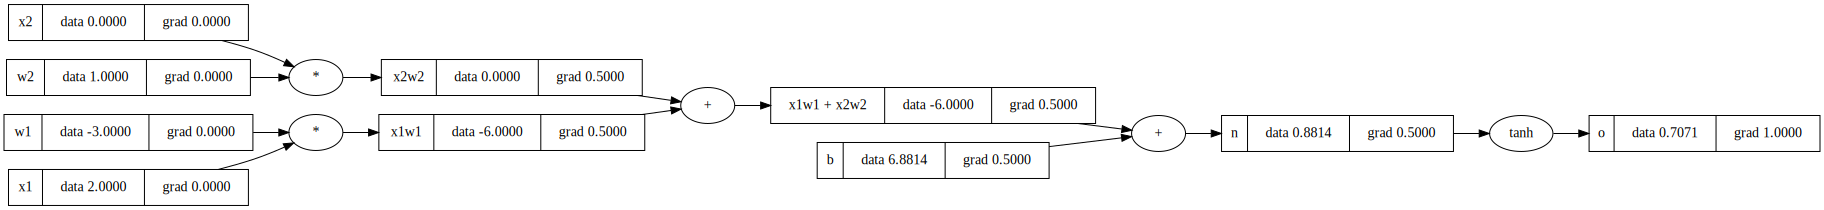

In [143]:
# STEP 4 - same as STEP3
x1w1.grad = 0.5
x2w2.grad = 0.5
draw_dot(o)

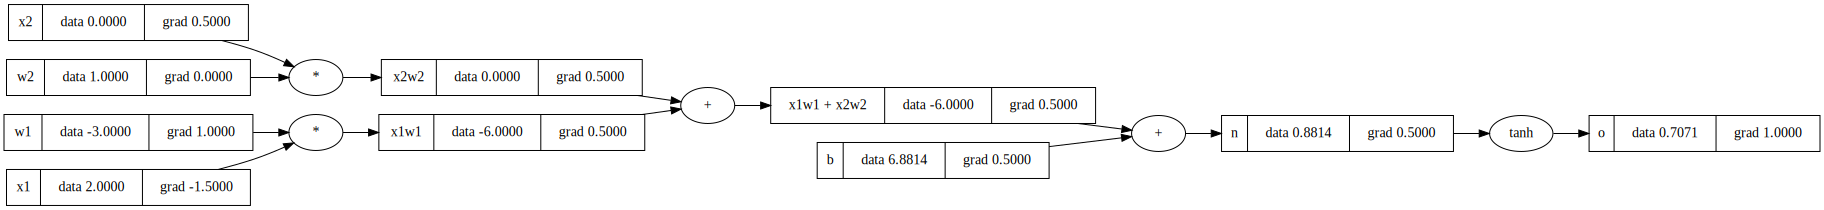

In [144]:
# STEP 5
# what id do/dx1 ? 
# we know that x1w1 = x1 * w1 so dx1w1/dx1 = w1 and dx1w1/w1 = x1

# apply chain rule : do/dx1 = do/dx1w1 * dx1w1/dx1 (which is w1) = 0.5 * -3.0
# and also : do/dw1 = do/dx1w1 * dx1w1/dw1 (which is x1) = 0.5 * 2
x1.grad = 0.5 * -3.0
w1.grad = 1.0


# similarly x2.grad = do/dx2?
# do/dx2 = do/dw2x2 * dw2x2/dx2 (which is w2) so it means that x2.grad = x2w2.grad * w2.data
x2.grad = 0.5 * 1.0
w2.grad = 0.5 * 0
draw_dot(o)

To implement backpropagation now we go back to Value object and create self._backward = lambda: None
After implementation of _backward functions we can re-run the backpropagation to check if it works

In [145]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias
b = Value(6.8813735870195432, label='b')
# according to neuron model (wikipedia)
# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

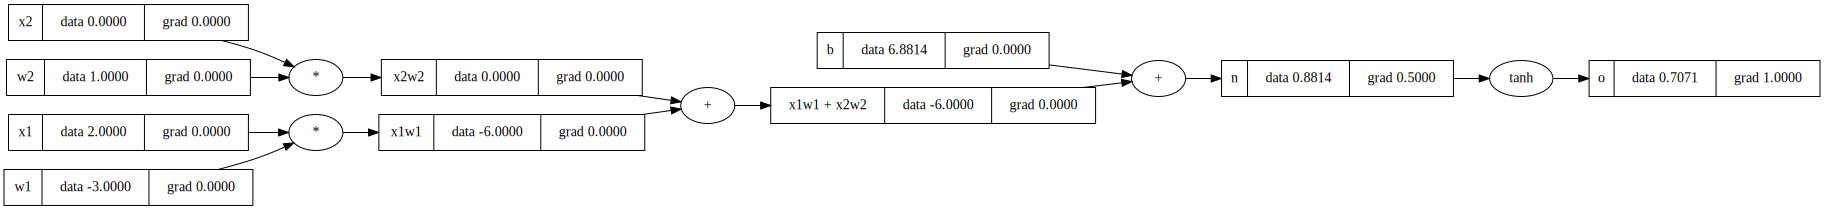

In [146]:
# initialize o.grad
o.grad = 1.0
o._backward()
draw_dot(o)

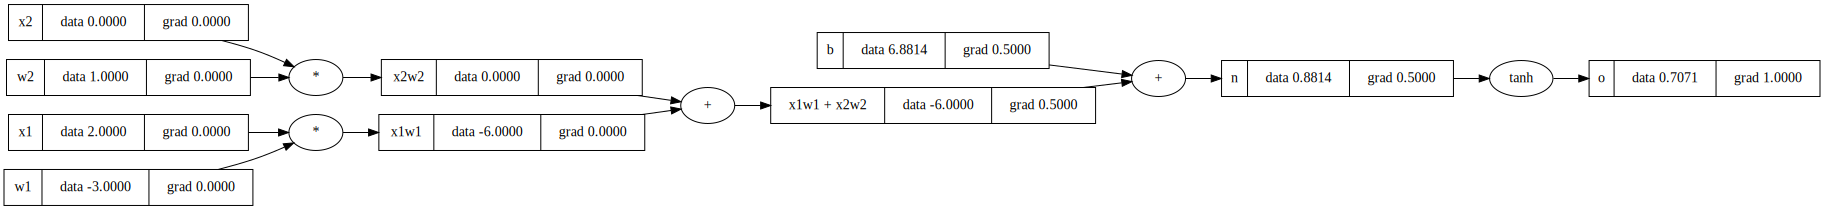

In [147]:
n._backward()
draw_dot(o)

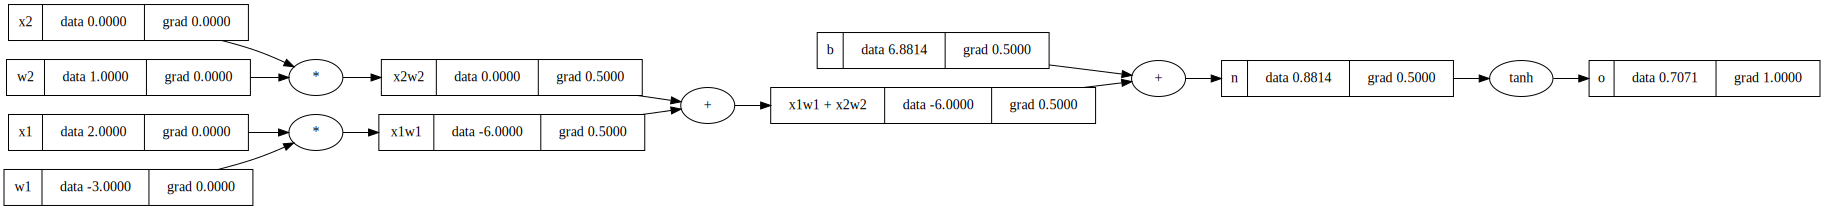

In [148]:
x1w1x2w2._backward()
draw_dot(o)

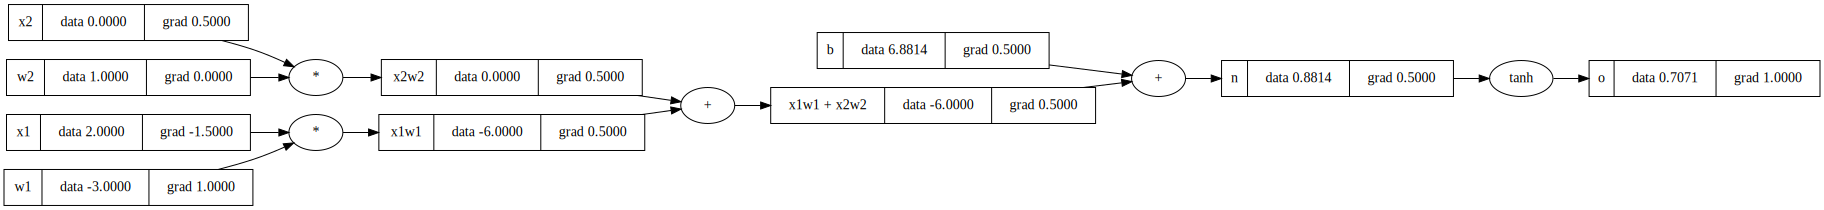

In [149]:
x1w1._backward()
x2w2._backward()
draw_dot(o)

In [150]:
# building topological sort of nodes so we don't have to call backward function numerous times
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

[Value(data=6.881373587019543, grad=0.4999999999999999),
 Value(data=2.0, grad=-1.4999999999999996),
 Value(data=-3.0, grad=0.9999999999999998),
 Value(data=-6.0, grad=0.4999999999999999),
 Value(data=1.0, grad=0.0),
 Value(data=0.0, grad=0.4999999999999999),
 Value(data=0.0, grad=0.4999999999999999),
 Value(data=-6.0, grad=0.4999999999999999),
 Value(data=0.8813735870195432, grad=0.4999999999999999),
 Value(data=0.7071067811865476, grad=1.0)]

In [151]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias
b = Value(6.8813735870195432, label='b')
# according to neuron model (wikipedia)
# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

o.backward()


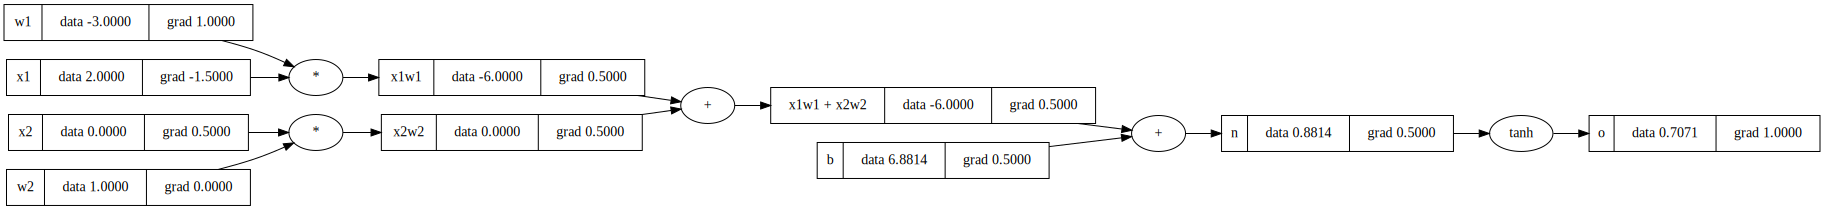

In [152]:
draw_dot(o)

In [153]:
a = 2
b = Value (2.0)
a * b

Value(data=4.0, grad=0.0)

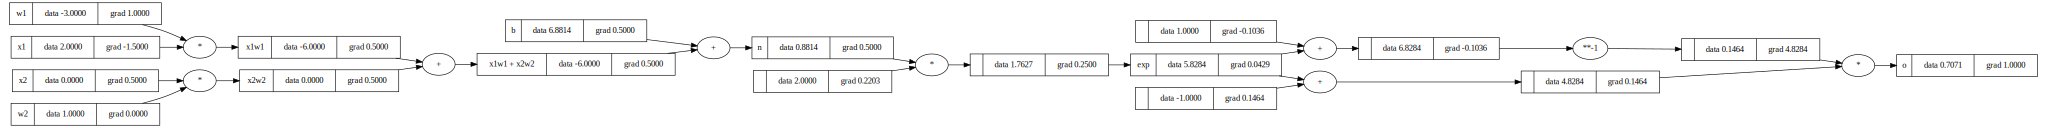

In [154]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias
b = Value(6.8813735870195432, label='b')
# according to neuron model (wikipedia)
# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

# break tanh
e = (2*n).exp()
o = (e - 1)/(e + 1)
o.label = 'o'

o.backward()
draw_dot(o)

In [155]:
# draw_dot(n(x))

In [156]:

x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.8366872644638969, grad=0.0)

In [157]:
# let's create a simple dataset with 4 possible inputs into the nn
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
] 

ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [164]:
# train the network now
for k in range(200):
    # forward pass:
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    # backward pass:
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # update
    for p in n.parameters():
        p.data += -0.1 * p.grad
    
    if k % 1 == 0:
        print(f"Step: {k} loss: {loss.data}")

Step: 0 loss: 0.002716622569041036
Step: 1 loss: 0.0027003760020020517
Step: 2 loss: 0.0026843132469146166
Step: 3 loss: 0.0026684312555617347
Step: 4 loss: 0.0026527270461742993
Step: 5 loss: 0.0026371977016394713
Step: 6 loss: 0.0026218403677667574
Step: 7 loss: 0.0026066522516091303
Step: 8 loss: 0.002591630619837648
Step: 9 loss: 0.0025767727971672907
Step: 10 loss: 0.002562076164832301
Step: 11 loss: 0.002547538159109043
Step: 12 loss: 0.002533156269884955
Step: 13 loss: 0.0025189280392716763
Step: 14 loss: 0.0025048510602608508
Step: 15 loss: 0.00249092297542116
Step: 16 loss: 0.0024771414756349615
Step: 17 loss: 0.0024635042988733024
Step: 18 loss: 0.00245000922900791
Step: 19 loss: 0.0024366540946587833
Step: 20 loss: 0.0024234367680761914
Step: 21 loss: 0.0024103551640560677
Step: 22 loss: 0.002397407238887258
Step: 23 loss: 0.002384590989329951
Step: 24 loss: 0.0023719044516239884
Step: 25 loss: 0.0023593457005260687
Step: 26 loss: 0.0023469128483748734
Step: 27 loss: 0.00233

In [163]:
print(loss)

Value(data=0.0027330560645475867, grad=1.0)


In [160]:
print(n.layers[0].neurons[0].w[0].grad)
print(n.layers[0].neurons[0].w[0].data)

-0.0004067905542835652
0.9530360378832875


In [161]:
ypred

[Value(data=0.9761769121895132, grad=-0.04764617562097362),
 Value(data=-0.9810143945819555, grad=0.03797121083608901),
 Value(data=-0.9693497254743222, grad=0.061300549051355624),
 Value(data=0.9705785110823343, grad=-0.058842977835331434)]

In [162]:
# gather all parameters of NN:
n.parameters()

[Value(data=0.9530360378832875, grad=-0.0004067905542835652),
 Value(data=-0.29893425522461675, grad=-0.00035103322013817434),
 Value(data=-0.9829575790101039, grad=0.003080452457345368),
 Value(data=-0.35988274279405535, grad=0.00048753478624778907),
 Value(data=-0.5600389041269817, grad=0.0005503252926290892),
 Value(data=1.1779529612147626, grad=-0.00019256576729223258),
 Value(data=-0.08816361652719792, grad=0.0011595635237436751),
 Value(data=1.010727037471726, grad=0.0003290144604662611),
 Value(data=0.9474796915787979, grad=-0.00023150464809509376),
 Value(data=0.3804700627656948, grad=-0.0004377207267533626),
 Value(data=-0.2634580752369558, grad=-0.0005846322337886109),
 Value(data=0.46456284440361895, grad=-0.0004651726612049815),
 Value(data=-0.17082494405524243, grad=0.0005305759276144264),
 Value(data=-0.31604946499406333, grad=-0.0002178261950033434),
 Value(data=-0.025375064363543715, grad=0.0005717723370362345),
 Value(data=-1.0046549987122722, grad=0.000253895490080696